In [1]:
%pip install -q emnist pandas pyarrow numpy matplotlib seaborn scikit-learn xgboost tensorflow
%reset -f

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown
from itertools import product

# ML packages
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ParameterGrid
# XGBoost (SVM)
from xgboost import XGBClassifier

# Constants
SIZE = 28

In [3]:
# Load tabular dataset 
datafile = '~/Downloads/csd.csv'
df = pd.read_csv(datafile)

# Trim unused columns
df_trimmed = df.loc[:, ~df.columns.isin(['feature', 'grade', 'stage'])] 
print(df_trimmed.shape)
df_trimmed.head()

# Split dataset into features and outcomes
features = df_trimmed.drop('OS_vital_status', axis = 1)
outcome = df_trimmed['OS_vital_status']

# Find categorical columns
cat_cols = features.select_dtypes(include = ['object']).columns
cat_cols

# Convert categorical predictors to dummy variables
features['gender'].value_counts()
features = pd.get_dummies(features, columns = cat_cols, drop_first = True)
print(features.shape)
features.head(10)

# Convert binary outcome to dummy variables
outcome = pd.get_dummies(outcome, drop_first = True)
outcome

# Convert to numpy arrays
features = features.values
print(features.shape)
outcome = outcome.values
print(outcome.shape)

(243, 16379)
(243, 16378)
(243, 16378)
(243, 1)


In [5]:
# Hyperparameter grid
xgb_param_grid = {'n_estimators': [50, 100, 200, 500], 'max_depth': [1, 2, 3, 4, 5, 6], 'eta': [0.1, 0.3]}
scoring_metric = 'accuracy'

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, outcome, random_state = 42, test_size = 0.2)

# Hyperparameter tuning
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Initializing scores
best_score = 0
best_model = None

for param_combination in ParameterGrid(xgb_param_grid):
    xgb_classifier = XGBClassifier().set_params(**param_combination)
    fold_scores = []

    # 3.A. Split train using k-fold with the number of folds 
						# equal to the number of parameter combinations
    for train_index, test_index in kf.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # 3.B. Train on k-fold split
        xgb_classifier.fit(X_fold_train, y_fold_train)

        # 3.C. Record performance of each set of parameters
        y_pred = xgb_classifier.predict(X_fold_test)
        fold_score = accuracy_score(y_fold_test, y_pred)
        fold_scores.append(fold_score)

    # 3.D. Use winning set of parameters to train model on full training set
    avg_score = np.mean(fold_scores)
    if avg_score > best_score:
        best_score = avg_score
        best_model = xgb_classifier.get_params()

# Display winning model
print(f"Best Model Parameters: {best_model}")
print(f"Best Model Average Cross-Validation Score: {best_score}")


Best Model Parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 1, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.1}
Best Model Average Cross-Validation Score: 0.7780026990553306


              precision    recall  f1-score   support

       Alive       0.62      0.96      0.75        27
        Died       0.86      0.27      0.41        22

    accuracy                           0.65        49
   macro avg       0.74      0.62      0.58        49
weighted avg       0.73      0.65      0.60        49

Accuracy: 0.6530612244897959


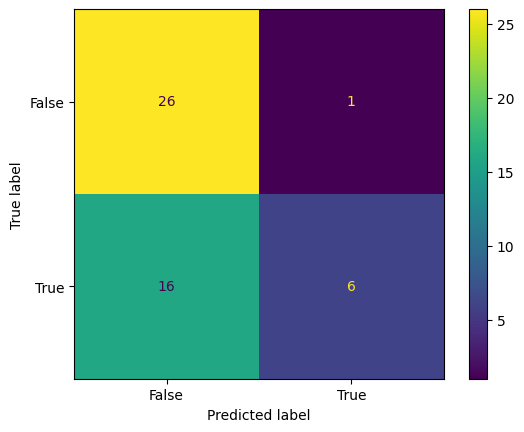

In [8]:
# Train best model on full training dataset
xgb_clf = XGBClassifier(**best_model)
xgb_clf.fit(X_train, y_train)

# Evaluate model
y_pred = xgb_clf.predict(X_test)

# Calculate performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary', zero_division = 1)
rec = recall_score(y_test, y_pred, average = 'binary')
f1 = f1_score(y_test, y_pred, average = 'binary')
cm = confusion_matrix(y_test, y_pred, labels = xgb_clf.classes_)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names = ['Alive', 'Died']))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')